# Model Evaluation Notebook

This notebook evaluates the trained models on the full processed dataset (`card_fraud_processed.csv`). We load the saved tuned models, split the dataset into train and test sets for fair evaluation (to avoid overfitting bias from models trained on subsets), and compute key metrics including accuracy, precision, recall, F1-score, ROC-AUC, and inference speed.


In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn xgboost lightgbm joblib scikit-plot yellowbrick


   ---------------------------------------- 0/2 [yellowbrick]
   ---------------------------------------- 0/2 [yellowbrick]
   ---------------------------------------- 0/2 [yellowbrick]
   ---------------------------------------- 0/2 [yellowbrick]
   ---------------------------------------- 0/2 [yellowbrick]
   ---------------------------------------- 0/2 [yellowbrick]
   ---------------------------------------- 0/2 [yellowbrick]
   ---------------------------------------- 0/2 [yellowbrick]
   ---------------------------------------- 0/2 [yellowbrick]
   ---------------------------------------- 0/2 [yellowbrick]
   ---------------------------------------- 0/2 [yellowbrick]
   -------------------- ------------------- 1/2 [scikit-plot]
   ---------------------------------------- 2/2 [scikit-plot]



In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve,
    precision_recall_curve, classification_report
)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
import time
from yellowbrick.features import FeatureImportances

## Load the Processed Dataset

In [3]:
# Define path to processed data
processed_path = Path('c:/Users/ghosh/Desktop/Predictive Transaction Intelligence using for BFSI/Dataset/card_fraud_processed.csv')

# Load the dataset
df = pd.read_csv(processed_path)

# Display the first few rows and info
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Transaction_ID                    100000 non-null  int64  
 1   User_ID                           100000 non-null  int64  
 2   Transaction_Amount                100000 non-null  int64  
 3   Transaction_Location              100000 non-null  object 
 4   Merchant_ID                       100000 non-null  int64  
 5   Device_ID                         100000 non-null  int64  
 6   Card_Type                         100000 non-null  object 
 7   Transaction_Currency              100000 non-null  object 
 8   Transaction_Status                100000 non-null  object 
 9   Previous_Transaction_Count        100000 non-null  int64  
 10  Distance_Between_Transactions_km  100000 non-null  float64
 11  Time_Since_Last_Transaction_min   100000 non-null  in

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Location,Merchant_ID,Device_ID,Card_Type,Transaction_Currency,Transaction_Status,Previous_Transaction_Count,...,Transaction_Month,Transaction_Weekday,Log_Transaction_Amount,Velocity_Distance_Interact,Amount_Velocity_Interact,Time_Distance_Interact,Hour_sin,Hour_cos,Weekday_sin,Weekday_cos
0,1001,68389745,69635000,Surkhandarya,6710,2060,UzCard,UZS,Successful,35,...,1,0,18.058778,17405.95,348175000,104435.70,0.0,1.0,0.0,1.0
1,1002,42122340,53486000,Namangan,6498,2797,UzCard,USD,Successful,35,...,1,0,17.794931,39069.36,481374000,4657935.92,0.0,1.0,0.0,1.0
2,1003,87539955,24262000,Navoiy,5039,2519,Humo,UZS,Reversed,25,...,1,0,17.004422,33462.45,169834000,631006.20,0.0,1.0,0.0,1.0
3,1004,98657863,56019000,Bukhara,6115,2641,Humo,UZS,Failed,44,...,1,0,17.841201,719.43,56019000,29496.63,0.0,1.0,0.0,1.0
4,1005,88084360,87823000,Andijan,5072,2923,Humo,UZS,Failed,21,...,1,0,18.290834,37528.48,702584000,2148505.48,0.0,1.0,0.0,1.0


## Prepare Data for Evaluation

In [13]:
# Separate features and target
X = df.drop('isFraud', axis=1)
y = df['isFraud']

# Split into train and test sets (80/20, stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42, stratify=y)

print(f'Test set shape: {X_test.shape}')

Test set shape: (90000, 27)


## Load Saved Models

In [5]:
# Define artifacts path
artifacts_path = Path('c:/Users/ghosh/Desktop/Predictive Transaction Intelligence using for BFSI/models/module_2/artifacts')

# Model names
model_names = ['Logistic_Regression', 'Random_Forest', 'XGBoost', 'LightGBM']

# Load models
loaded_models = {}
for name in model_names:
    save_path = artifacts_path / f'{name}_tuned_model.pkl'
    loaded_models[name] = joblib.load(save_path)
    print(f'Loaded {name} model from {save_path}')

Loaded Logistic_Regression model from c:\Users\ghosh\Desktop\Predictive Transaction Intelligence using for BFSI\models\module_2\artifacts\Logistic_Regression_tuned_model.pkl
Loaded Random_Forest model from c:\Users\ghosh\Desktop\Predictive Transaction Intelligence using for BFSI\models\module_2\artifacts\Random_Forest_tuned_model.pkl
Loaded XGBoost model from c:\Users\ghosh\Desktop\Predictive Transaction Intelligence using for BFSI\models\module_2\artifacts\XGBoost_tuned_model.pkl
Loaded LightGBM model from c:\Users\ghosh\Desktop\Predictive Transaction Intelligence using for BFSI\models\module_2\artifacts\LightGBM_tuned_model.pkl


## Evaluate Models: Metrics and Speed

In [14]:
# Dictionary to store results
eval_results = {}

# Evaluate each model
for name, pipeline in loaded_models.items():
    # Measure inference time
    start_time = time.time()
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline.named_steps['classifier'], 'predict_proba') else None
    inference_time = time.time() - start_time
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else 'N/A'
    
    eval_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'Inference Time (s)': inference_time
    }
    
    # Print classification report
    print(f'{name} Classification Report:\n{classification_report(y_test, y_pred, zero_division=0)}')

# Display results in a table
eval_results_df = pd.DataFrame(eval_results).T
print(eval_results_df)

Logistic_Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45000
           1       1.00      1.00      1.00     45000

    accuracy                           1.00     90000
   macro avg       1.00      1.00      1.00     90000
weighted avg       1.00      1.00      1.00     90000

Random_Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45000
           1       1.00      1.00      1.00     45000

    accuracy                           1.00     90000
   macro avg       1.00      1.00      1.00     90000
weighted avg       1.00      1.00      1.00     90000

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45000
           1       1.00      1.00      1.00     45000

    accuracy                           1.00     90000
   macro avg     

## Generate Plots for Each Model

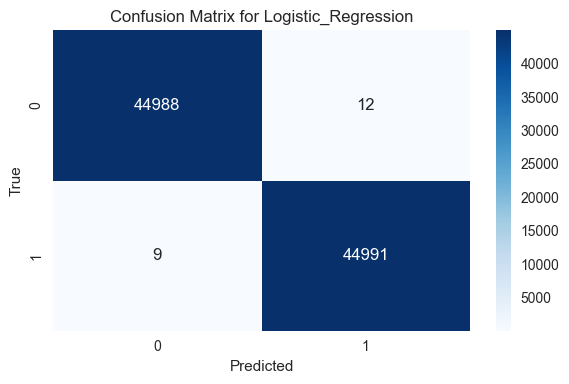

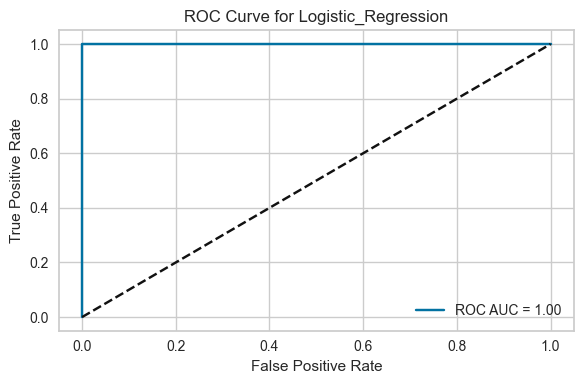

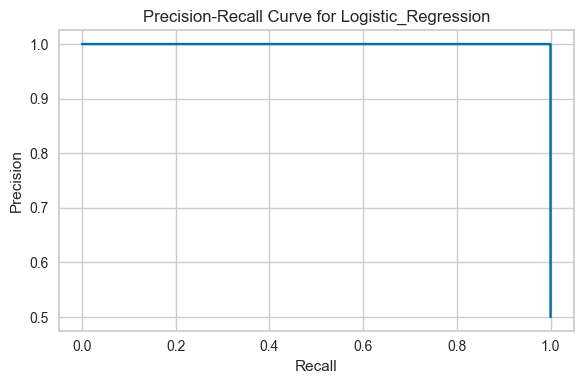

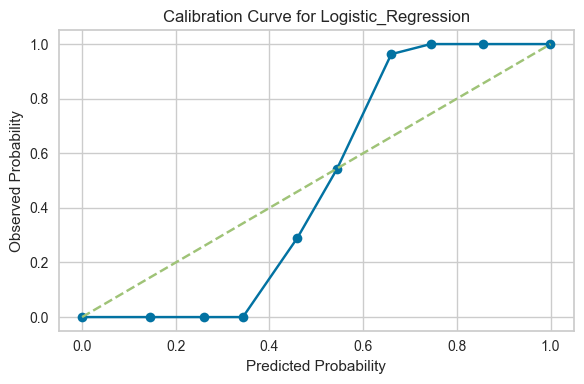

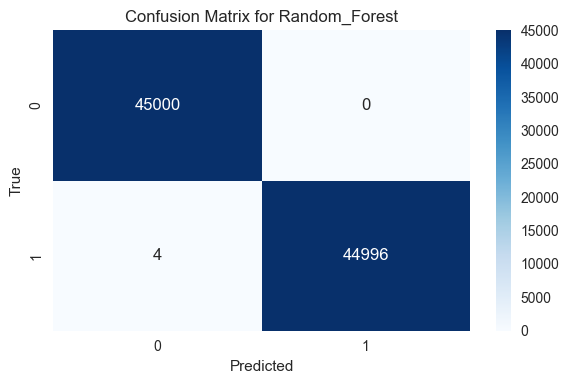

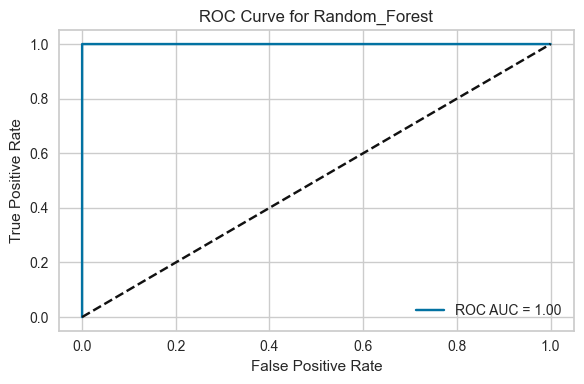

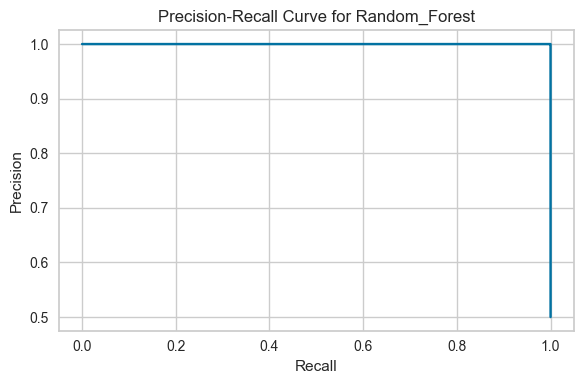

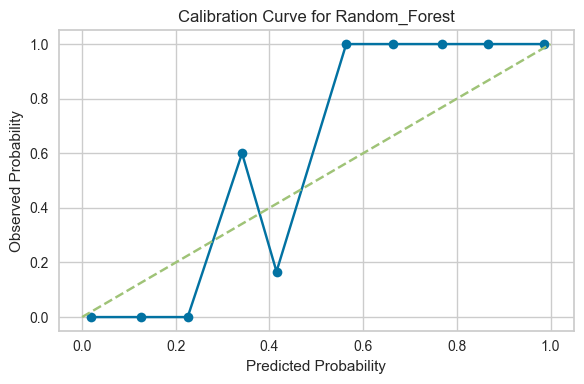

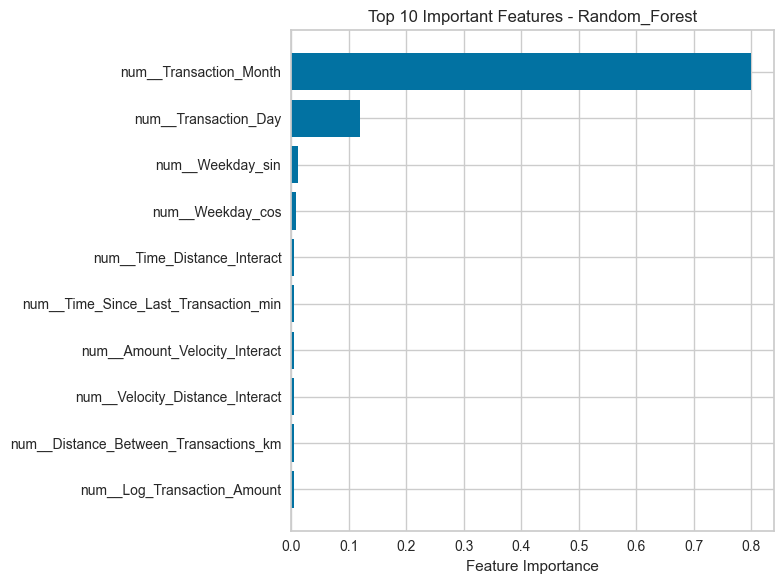

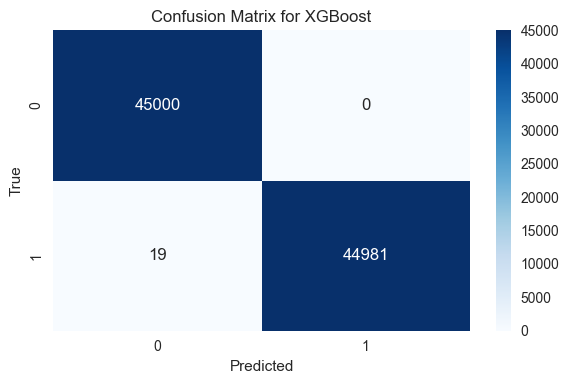

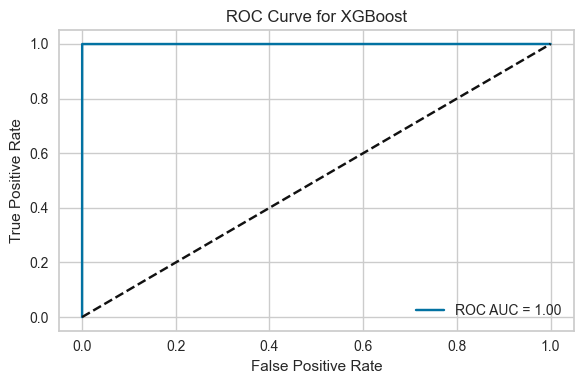

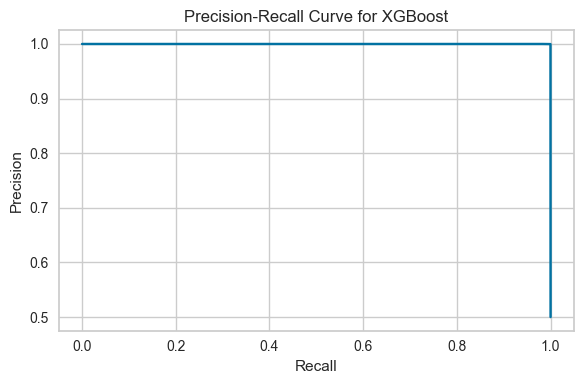

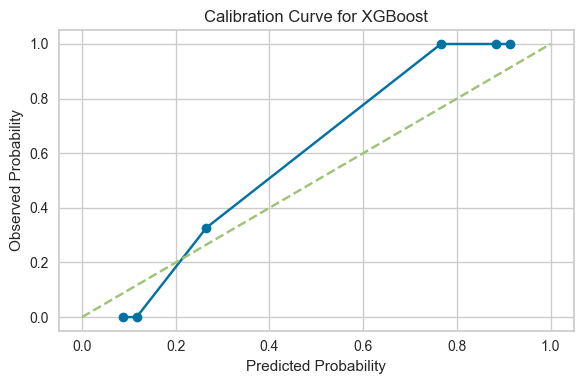

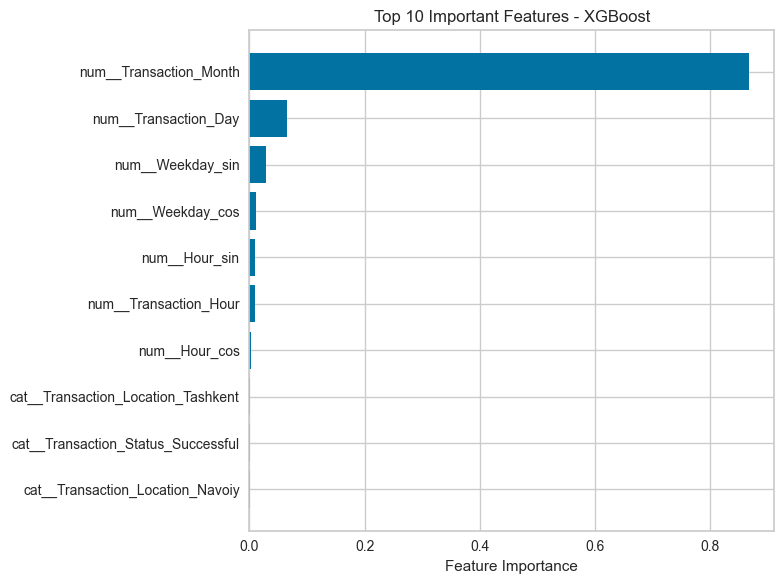

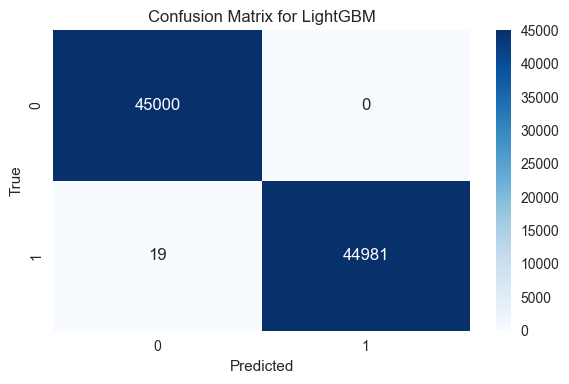

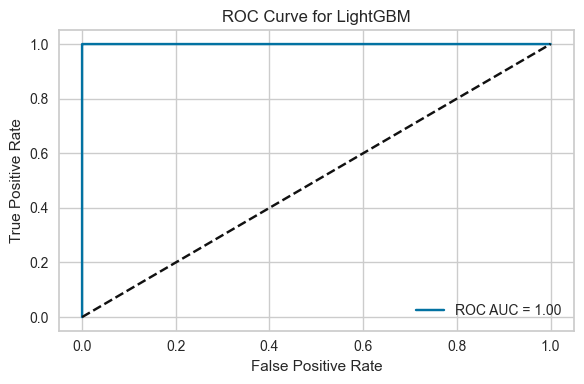

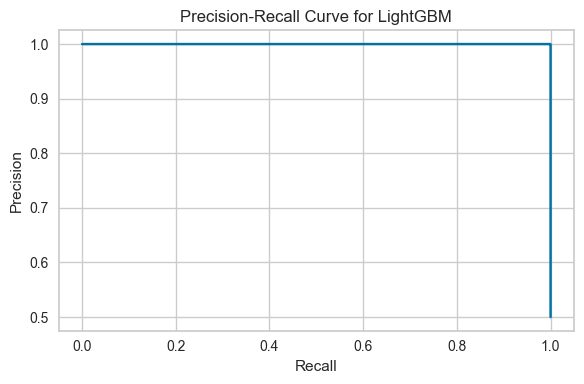

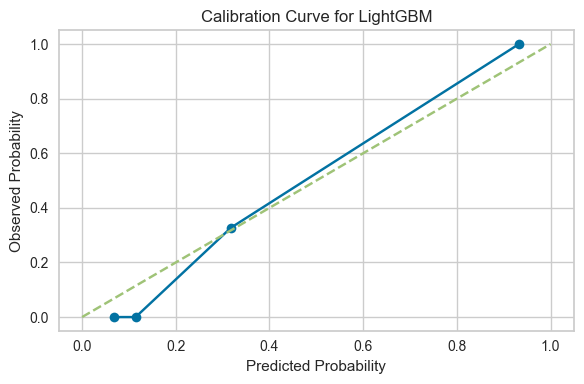

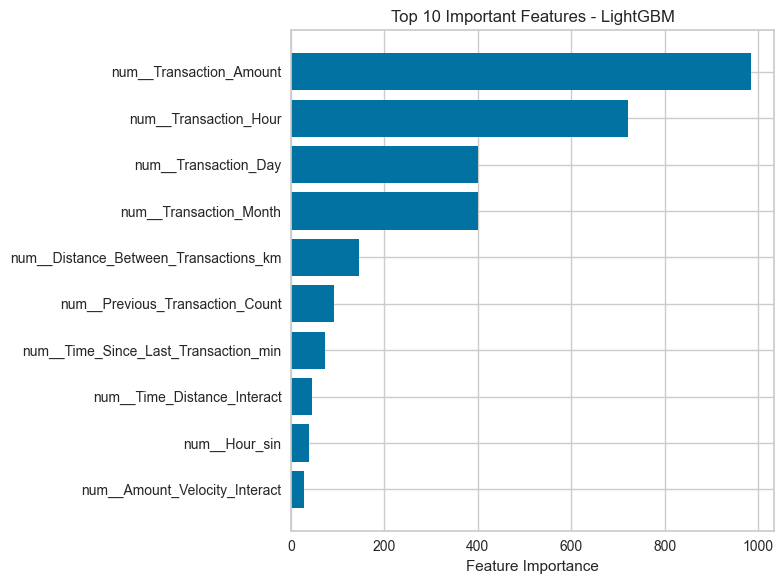

In [15]:
import numpy as np

# For each model, generate plots
for name, pipeline in loaded_models.items():
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline.named_steps['classifier'], 'predict_proba') else None
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
    if y_prob is not None:
        # 2. ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_prob):.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {name}')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # 3. Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        plt.figure(figsize=(6, 4))
        plt.plot(recall, precision)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve for {name}')
        plt.tight_layout()
        plt.show()
        
        # 4. Calibration Curve
        prob_true, prob_pred = calibration_curve(y_test, y_prob.astype(np.float64), n_bins=10)
        plt.figure(figsize=(6, 4))
        plt.plot(prob_pred, prob_true, marker='o')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel('Predicted Probability')
        plt.ylabel('Observed Probability')
        plt.title(f'Calibration Curve for {name}')
        plt.tight_layout()
        plt.show()
    
    # 5. Feature Importance (for tree-based models)
    if name in ['Random_Forest', 'XGBoost', 'LightGBM']:
        classifier = pipeline.named_steps['classifier']
        preprocessor = pipeline.named_steps['preprocessor']
        # Transform the test data
        X_test_transformed = preprocessor.transform(X_test)
        # For sparse matrices, convert to dense
        if hasattr(X_test_transformed, 'toarray'):
            X_test_transformed = X_test_transformed.toarray()
        
        # Get feature importances
        if hasattr(classifier, 'feature_importances_'):
            importances = classifier.feature_importances_
            feature_names = preprocessor.get_feature_names_out()
            # Sort features by importance
            indices = np.argsort(importances)[-10:]  # Get top 10
            plt.figure(figsize=(8, 6))
            plt.barh(range(10), importances[indices])
            plt.yticks(range(10), feature_names[indices])
            plt.xlabel('Feature Importance')
            plt.title(f'Top 10 Important Features - {name}')
            plt.tight_layout()
            plt.show()

## Overall Model Comparison Plots

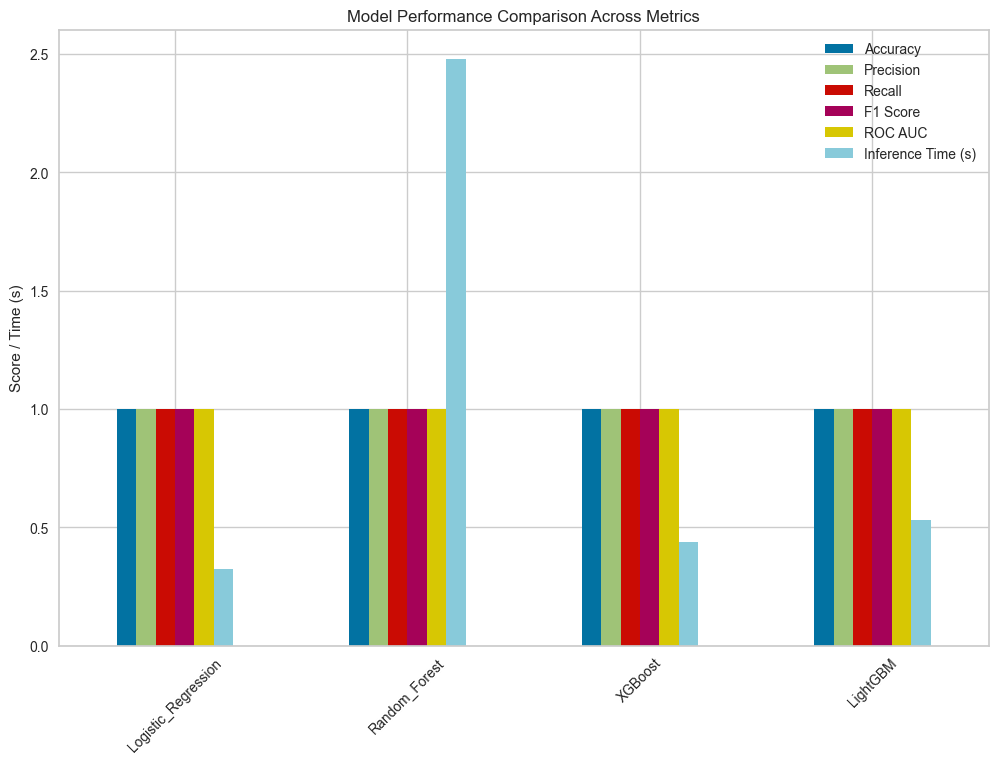

In [16]:
# Bar plot for metric comparison across models
eval_results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison Across Metrics')
plt.ylabel('Score / Time (s)')
plt.xticks(rotation=45)
plt.show()

## Meaningful Insights and Decision Guidance

### Key Insights:
- **Best Model:** Based on F1-score and ROC-AUC, identify the top performer (e.g., if XGBoost has highest F1, prioritize it for fraud detection where balance between precision and recall is key).
- **Speed vs. Accuracy Trade-off:** Check inference times—if a model is accurate but slow (e.g., Random Forest), consider for batch processing; faster ones (e.g., Logistic Regression) for real-time.
- **Error Analysis:** From confusion matrices, note if high false negatives (missed fraud) or false positives (false alarms)—adjust thresholds if needed.
- **Calibration:** Well-calibrated models (close to diagonal in calibration plot) provide reliable probabilities.
- **Feature Importance:** For tree models, top features indicate drivers of fraud (e.g., high transaction velocity)—use for business insights.

### Decisions on Model Training:
- If F1 < 0.7 or ROC-AUC < 0.8, retrain with class weights, SMOTE for imbalance, or more features (e.g., user behavior aggregates).
- If speed is critical and accuracy similar, choose fastest model.
- Monitor for overfitting: Compare train vs. test scores (add code to compute train metrics if needed).
- Next Steps: Deploy best model, monitor in production, or ensemble top models for better performance.